Sundew Algorithmic Design
=======================

Sundew was built because PDS was too slow for message routing, which typically had:

* hundreds of thousands of different products to route (order of 300,000 products in the routing table.)
* several dozen destinations.
* need to route 20 messages per second during the day, but during an outage, need to recover the failure quickly (say 100 messages per second, so a one hour outage would be recovered in 12 minutes or so.)
* we were seeing peak routing speed in the teens to low 20's. It could keep up with routine traffic, but would often fall behind during traffic spurts, and took a very long time to recover after outages.


Sundew, a replacement implementation of PDS, was eventually made to solve this problem.  It made the following alrogithimic design changes:


Eliminate Dispatcher
-----------------------------

Having a single process doing the routing limits scaling.
Instead, have each receiver identify the outputs for files it receives.
This means operating multiple routing engines in parallel, which gives the potential for name clashes in the destination directories (if two receivers choose to same names for different data)   

* Make sure all file names chosen for routing are unique.

On systems with more cores available, having more processes able to route is a benefit.
Comparing regular expressions is a cpu-bound problem. With 10 receivers, one can expect a 10-fold improvement in routing performance... eg. the routing performance of the server should scale with the number of products being received.

It should also be noted that while scanning directories is an i/o bound process with lots of waiting, routing is a completely cpu bound process, so combining the two doesn't worsen the overall load of the receivers substantially. 



Eliminate Log Locking
--------------------------------

Contention for writing the combined log of all processes is performance limiting, and wastes a great deal of cpu on locks to serialize access. if each process writes its own log, there is no contention for the log file. Dropping the constraint of a single log file unlocks a great deal of performance potential.

From an architectural perspective, this is just a pure win, there was a hard limit on absolute performance, and it is completely eliminated.



Dictionary Pre-Routing
---------------------------------

Even if we parallelize routing, the algorithm itself is quite intensive. for 10 destinations, with 10 regular expressions each, that means 100 regular expressions
to evaluate (slightly less, because of shortcuts from exclusion masks (rejects) but the order of magnitude is about right.)

Added the use of a python dictionary listing product keys, and a set of destinations associated with each key.  So there are now two steps to routing, the first narrows down the number of destinations to a subset... say 2/10 of destinations, and then the regular expressions are only applied on that subset.

The cost to route a single product through the application (take it from seeing it in a reception directory to queuing it up for sending.) can be modelled as follows:
It is the regular expression comparisong that dominate the routing time, so 
just calculate how many regular expressions are needed, on average, to 
complete routing of a product.



* Sundew Routing cost: log(d) * s * (re/2) ... log(300000)* 10 * (10/2) = 18*10*5 = 900 

  * each receiver only routing for a single receiver.
  * d = 300000, the size of the product dictionary (around 300000) 
  * re = 10, the dictionary allows us to reduce the number of regex's used for product 
  * s is the subset of destinations chosen for a typical key (10)
  * dictionary lookup time is a log of the number of different product keys to assign.
  
It is important to note that S grew substantially once Sundew was in place,
we peaked at about 500 senders... with PDS, that would have meant 25000 regex comparisons per product routed, while Sundew routing algorithmic cost is independent of the number of senders extant.

Note that a single process does all routing in PDS, where each receiver (initial configurations had R=10) distributed routing duties to each receiver, giving 10x available algorithmic speedup, as routing is embarassingly parallel (completely perallelizable.)

**NOTE:** this algorithm only benefits "message" type routing with the dictionary. for file type routing, used in PDS traditionally, we fall back on pure regexes.




Write it in Python
------------------------

Sundew was built in Python. Industry lore is that Python is much slower than C, the measurable amounts vary, but as a rule of thumb, one can attribute approximately an order of magnitude there as well. It was judged safe to use Python in this case because the application is entirely i/o bound, and thus the speed of C was not material to the problem at hand. When using python, code is much simpler to write, and much shorter. the PDS application was approximately 150,000 lines of C clode. The Python application is 25,0000 lines.

Sundew also replaced another message router, called "Tandem Apps", which was 450,000 lines of code in proprietary language. replacing 600,000 lines of code is a major project, writing 25,000 lines is a biggish script. So a 96% reduction in the source code size.
This choice:

* made the project feasible.

* made the algorithms in use far simpler to understand and implement.









Eliminate Dispatcher
-----------------------------

* replace single task routing for all receivers
* every receiver queues products for senders.
* routing performance expands as a function of the number of receivers.



Dictionary Pre-Routing
---------------------------------

* map bulletin names to a key, list the keys in a table (aka python dictionary) that lists senders.
* selects a subset of senders to which their regex's are applied.


Sundew Routing cost:
--------------------------------

* Rp = 900 = log(d) * s * (re/2)
* r = 10, each receiver only routing for a single receiver.
* d = 300000, the size of the product dictionary (around 300000) 
* n = the length of each key.
* re = 10, the dictionary allows us to reduce the number of regex's used for product 
* s is the subset of destinations chosen for a typical key (10)
* dictionary lookup time is a log of the number of different product keys to assign.
 

In [102]:
from math import log

r=10 # number of receivers, each receiver is routing for itself alone. naturally de-composing the routing problem.
d=300000 # number of products in the routing table, pre-existing table used by previous system.
re=10 # number of regexes in each sender, given that pre-routing with the dictionary has occurred.
s=10 # number of destinations selected by Pre-Routing.
n=10 # the number of characters in each key.

# cost to look up each string to find a corresponding integer is in the log(d)
Lum=log(d,2) # map key string to a token number.
Luk=log(d,2) # lookup the token in the dictionary.

# cost to search a dictionary to find a match. (integer ops...)
Rpr = 2*log(d,2)

#convert integer ops, to RE ... 
RE=100

#Client side routing cost:

Rpc=s*RE*re/2

RP=Rpr+Rpc

print(f"total routing cost, pre product, done by each receiver: {round(Rp)} instructions")

print( f"in terms of load distribution, the pre-routing falls on the receivers: {round(Rpr)} " )
print( f"and the rest {Rpc} falls on the senders" )

# for files, instead of messages.


total routing cost, pre product, done by each receiver: 181946 instructions
in terms of load distribution, the pre-routing falls on the receivers: 36 
and the rest 5000.0 falls on the senders


Write it in Python
------------------------

* made the project feasible (10x smaller)

* made the algorithm simpler to understand an implement.

* problem i/o bound, python performance not an issue.



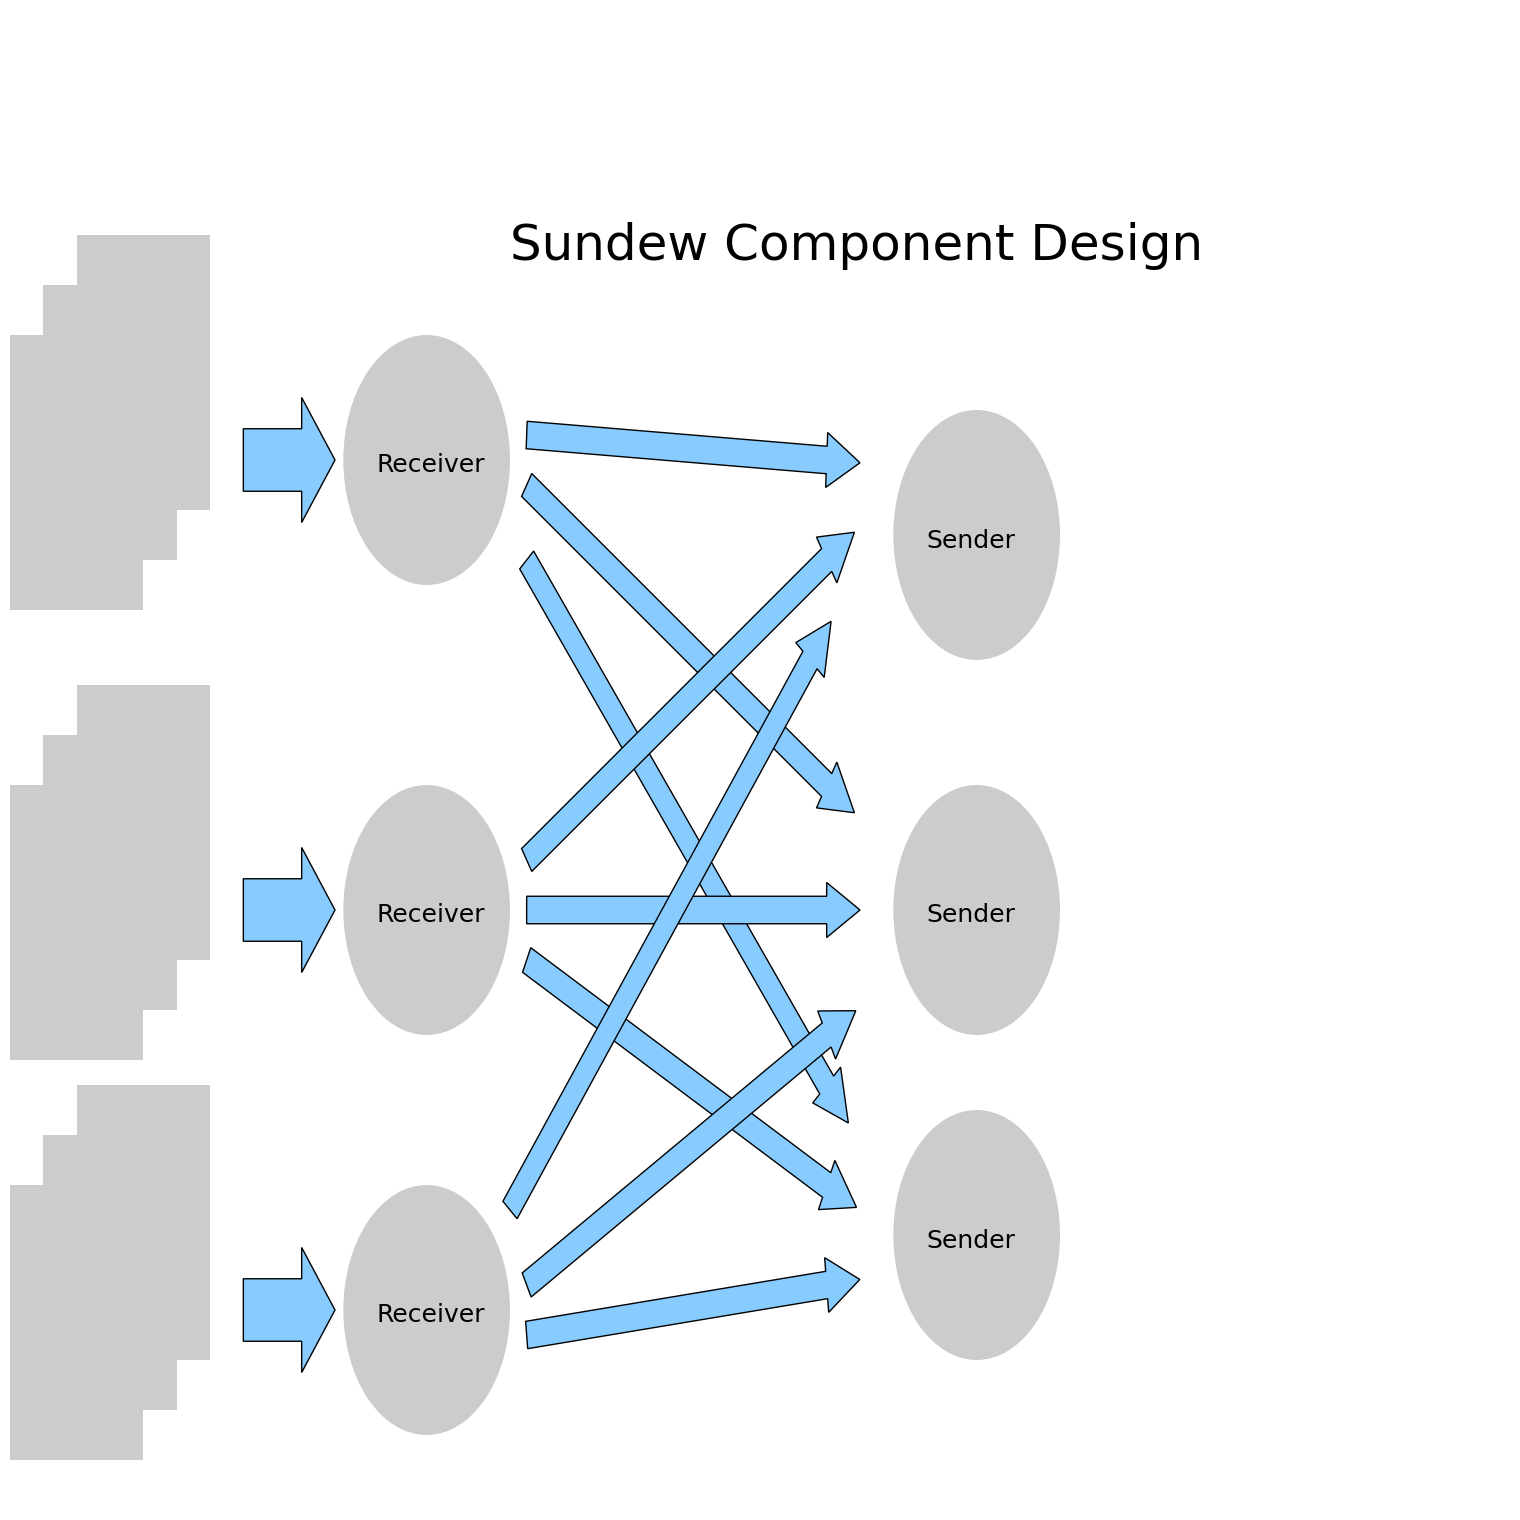

In [98]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

def directory_polygon(x,y,box_bg,arrow1):
   return [ Rectangle((x, y), 0.8, 1.1, zorder=1, fc=box_bg),
               Rectangle((x+0.2, y+0.2), 0.8, 1.1, zorder=2, fc=box_bg),
               Rectangle((x+0.4, y+0.4), 0.8, 1.1, zorder=3, fc=box_bg),
            FancyArrow(x+1.4,y+0.6, 0.35, 0, fc=arrow1, width=0.25, 
                       head_width=0.5, head_length=0.2),
            Circle((x+2.5, y+0.6), 0.5, fc=box_bg)
          ]


def create_base(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88',
                supervised=True):
    
    fig = plt.figure(figsize=(15, 15), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                 xticks=[], yticks=[], frameon=False)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    
    x=0
    y=3.6
    patches = []
    patches.extend(directory_polygon(x,y,box_bg,arrow1))        
    y=0.2
    patches.extend(directory_polygon(x,y,box_bg,arrow1))  
    y=1.8
    patches.extend(directory_polygon(x,y,box_bg,arrow1))
    
    len=1.8
    patches.extend( 
        [ 
          FancyArrow(3.1, 4.3, len, -0.1, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.1, 4.1, len, -1.2, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.1, 3.8, len, -2.1, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
                     
          FancyArrow(3.1, 2.6, len, 1.2, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.1, 2.4, len, 0, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.1, 2.2, len, -0.9, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
 
          FancyArrow(3.0, 1.2, len, 2.2, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
          FancyArrow(3.1, 0.9, len, 1, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),                     
          FancyArrow(3.1, 0.7, len, 0.2, fc=arrow1, width=0.11, head_width=0.22, head_length=0.2 ),
                     
          Circle((5.8, 3.9), 0.5, fc=box_bg),
          Circle((5.8, 2.4), 0.5, fc=box_bg),
          Circle((5.8, 1.1), 0.5, fc=box_bg)
        ])
    for p in patches:
        ax.add_patch(p)
    
    plt.text(2.2,0.75, 'Receiver', fontsize=18)
    plt.text(2.2,2.35, 'Receiver', fontsize=18)
    plt.text(2.2,4.15, 'Receiver', fontsize=18)
    plt.text(5.5,1.05, 'Sender', fontsize=18)
    plt.text(5.5,2.35, 'Sender', fontsize=18)
    plt.text(5.5,3.85, 'Sender', fontsize=18)
create_base()
plt.text(3.0, 5, 'Sundew Component Design',fontsize=36)
plt.show()

What difference did it make?
----------------------------------------


On a given linux server used to run both applications for benchmarking purposes:

* The original (PDS) C-code was performing 10-20 product routings per second, 

* Sundew (the python replacement) was peaking at 150 messages per second with files,

* Sundew was file system bound, and was also a message router, capable of routing over 400 messages/second.

It feels safe to say it was approximately an order of magnitude improvement in performance.

Note:: These tests were done in 2005, using, for example, hard disks for storage. Performance on current hardware is far superior. 


Bonus
----------

The original PDS application was surrounded by scripts and code to do many kinds of
name processing, and with the original built in C, this was done with shell scripts.
As a happy side-effect of implementing in Python, it became feasible to implement
a plugin architecture to customize processing in a much more efficient way.

Instead of forking of processes, as required by additional functionality in PDS, we could define routines that would be called from the python code. These routines could be written in Python, and thus save enormous amounts of overhead from the fork/reap pattern.

While plugin architectures can be implemented in C, they are much more daunting, and having operations people writing C is a high bar to customize processing.

So a great deal of peripheral, or customized processing was accellerated by the use of Python as the implementation language.
